<a href="https://colab.research.google.com/github/rudaruda/Python-SQLAlchemy-Experience/blob/main/Python_with_ElasticSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ETL ElasticSearch to PostgreSQL**

### Importando Bibliotecas

In [2]:
!pip install elasticsearch

     |████████████████████████████████| 327kB 8.5MB/s 


In [3]:
from elasticsearch import Elasticsearch

import os, json, sys, time, re,traceback, psycopg2
from datetime import date, datetime, time, timedelta

from sqlalchemy import Text, Column, Integer, BigInteger, String, Date, DateTime, Float, Boolean, create_engine, MetaData, Table, null
from sqlalchemy.dialects.postgresql import insert, JSON, JSONB
from sqlalchemy.orm import scoped_session, sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.inspection import inspect 

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Conectando Origem->Destino

In [4]:
# Connect Elasticsearch
try:
  es = Elasticsearch(
      ['https://%s/%s/?size=50&pretty' % (os.environ.get('HOST_ELASTIC'),os.environ.get('HOST_DATASET'))],
      http_auth=(os.environ.get('HOST_ELASTIC_USER'), os.environ.get('HOST_ELASTIC_PASS')),
      port=10202,
  )
  res = es.search(body={"query": {"match_all": {}}}, size=5)  # test consult
  len(res['hits']['hits'])                                    # test json
  print ("Connected! with ElasticSearch")                     # Success
except Exception as ex:
  print ("Error on ElasticSearch:", ex)                       # Fail

Connected! with ElasticSearch


In [5]:
DB_HOST, DB_PORT, DB_NAME, DB_USER, DB_PASS = os.environ.get('DB_HOST'), os.environ.get('DB_PORT'), os.environ.get('DB_NAME'), os.environ.get('DB_USER'), os.environ.get('DB_PASS')
db = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
try:
  conn = db.connect()
  print ("Connected! on PostGreSQL")
except Exception as ex: print ("Error on PostGreSQL:", ex)

Connected! on PostGreSQL


In [ ]:
# Check Table
metadata = MetaData(db)
# Tabela DXC API
tb_api = Table('tb_dxc_api', metadata,
      Column('da_dt', Date, primary_key=True), Column('da_dthr', DateTime), Column('da_dthr_lote', String)
      , Column('da_id', String, primary_key=True, nullable=False) #BigInteger ; Integer; autoincrement=False ; Sequence('poi_id_seq') to BIGSERIAL
      # Basic
      ,Column('da_requestid', String), Column('da_duration', Float), Column('da_env', String), Column('da_path', String), Column('da_endpoint', String), Column('da_platform', String)
      # Proposal
      ,Column('da_contractid', String), Column('da_proposal', String), Column('da_status', String), Column('da_pendencies', JSON), Column('da_errors', String), Column('da_errors_msg', String) 
      # Customer
      ,Column('da_cpf', String), Column('da_birthday', String), Column('da_phone', String), Column('da_mobile', String), Column('da_mail', String), Column('da_mother', String)
      # External
      ,Column('da_externalid', String), Column('da_externalpartnerid', String), Column('da_seller', String)
      # Postal
      ,Column('da_postalcode', String), Column('da_postalnumber', String), Column('da_postalcomple', String)
      ,Column('da_billpostalcode', String), Column('da_billpostalnumber', String), Column('da_billpostalcomple', String)
      # Bank
      ,Column('da_charge', String), Column('da_bank', String), Column('da_bankagency', String), Column('da_bankaccount', String)
      # Offer
      ,Column('da_offerinternet', String), Column('da_offerinternetprice', String), Column('da_offerpaytvprice', String), Column('da_offerpaytv', String), Column('da_offerphone', String), Column('da_offerphoneprice', String), Column('da_offermobile', String), Column('da_offermobileprice', String), Column('da_offer', String)
      # JSON
      ,Column('da_request', JSONB), Column('da_response', JSONB) 
)
# Implement the creation ; #metadata.create_all(checkfirst=True) ; metadata.reflect() ;
tb_api.create(checkfirst=True) #bind=engine,
# Tabela de Controle
tb_contr = Table('tb_control', metadata,
      Column('co_id', BigInteger, primary_key=True, autoincrement=True)
      ,Column('co_dthr', DateTime), Column('co_dt_ref', Date), Column('co_action', String), Column('co_info', String), Column('co_values', JSONB), Column('co_finish',Boolean)
)
tb_contr.create(checkfirst=True) #bind=engine,


In [ ]:
# reflect the tables with automap
Base = automap_base()
Base.prepare(db, reflect=True)

In [ ]:
# Set Table destiny, with automapper (mapper!)
tb_dxcapi = Base.classes.tb_dxc_api
tb_control = Base.classes.tb_control

In [ ]:
# Create Session
Session = sessionmaker(bind=db)
s = Session()

### Criando funções

In [ ]:
def QueryOneDay(d0=1): #Schedule ONE DAY FULLY and commit
  tt_read, tt_proposal, tt_error, tt_total = [0]*4
  dt_day = datetime.today() - timedelta(days=d0)
  print('QueryOneDay(%s)... %s' % (d0, dt_day.strftime('%Y-%m-%d')))
  tt_status = True
  jm = ['0m','15m','30m','45m']
  hstart, mstart = 0, 0
  if d0 < 0: sys.exit('  Please, insert day more than of "0"')
  if d0 >= 0: # not only == 0
      print('... consulta max dia ...')
      r_query = db.execute("""
      select 
        -- d::date, 
        coalesce(date_part('hour', d),0) as max_h, coalesce(date_part('minute', d),0) as max_m 
        , extract(day from current_date::timestamp - cast(d as date)::timestamp) as dd 
      from ( 
        select max(da_dthr) as d from tb_dxc_api where da_dt = (current_date - interval '%s days')::date --(select max(da_dt) from tb_dxc_api) 
      ) as a; 
      """ % (d0)).fetchone()
      try:
        ddstart = int( int(r_query[2]))
      except: ddstart = 0
      if ddstart >= 0: hstart, mstart = int( r_query[0]), int( int(r_query[1]) / 15)
  # for each Hour
  for i in range(hstart,24): #range(24) 
    if d0 == 0 and (i) > int(datetime.now().strftime("%H")) and (ddstart == 0 and hstart > 0 or hstart == 0): 
      print('...future hour...')
      continue
    for j, jj in enumerate(jm):
      if mstart > 0 and mstart > j: continue # next step
      mstart = 0
      xh, xm = i, jj                              #hora inicial, minuto inicial
      xmm = jm[j+1] if (j+1) < len(jm) else jm[0] #minuto final
      xhh = i+1 if xmm == jm[0] else i            #hora final
      xh, xhh = str(xh)+'H', str(xhh)+'H'         #formathora
      d0x = 'now-' + str(d0) + 'd/d+' + str(xh) + '+' + str(xm) #hora inicial formatada
      d1x = 'now-' + str(d0-1) + 'd/d' if xh == '23H' and xm == jm[-1] else 'now-' + str(d0) + 'd/d+' + str(xhh) + '+' + str(xmm) #hora final formatada
      d1x = d1x.replace('-0d/','/').replace("now--1d/d","now+1d/d")
      print('  Selecting...', d0x, d1x)
      row_data, dt_ref, q_read, q_total, q_proposal, q_other, q_error = QueryElasticParcial(d0x,d1x, dt_day.strftime('%Y-%m-%d'))
      tt_read+=q_read
      tt_proposal+=q_proposal
      tt_error+=q_error
      tt_total+=(q_proposal+q_other)
      tt_status = True if ((q_read == len(row_data) == q_total) * tt_status) else False
      a = '- [Read: %s] [Error: %s] [Proposal: %s]' % (tt_read, tt_error, tt_proposal), '(%s/%s/%s : %s)' % (q_read, len(row_data), q_total, tt_status)
      b = {'read': tt_read, 'error': tt_error, 'proposal':tt_proposal, 'sucess':tt_total, 'ok':tt_status}
      print('   ' + ', '.join(a))
      p = tb_control(co_dthr=datetime.now(), co_dt_ref=dt_ref, co_action='DXC to Database', co_info='%s, %s  %a' % (d0x,d1x,', '.join(a)), co_values=b, co_finish=0)
      s.add(p)
      s.commit()
      if q_total > 0: UpSert(row_data,1)
      #sys.exit()
  print('Finish! "QueryOneDay" %s' % (dt_day.strftime('%Y-%m-%d')))
  if not 'dt_ref' in vars():
      dt_ref = datetime.now() - timedelta(days=d0)
      dt_ref = dt_ref.date() #strftime('%m%d%y')  
      a,b = [],[]
  p = tb_control(co_dthr=datetime.now(), co_dt_ref=dt_ref, co_action='DXC to Database', co_info='Finish! %s' % (', '.join(a)), co_values=b, co_finish=1) #, 
  s.add(p)
  s.commit()
  ProcReport(dt_ref.strftime('%Y-%m-%d'))
  return 'Completo! Date: %s' % (dt_ref.strftime('%Y-%m-%d'))

#### UpSert (the secret)

In [ ]:
def UpSert(xdata,DoNotting=0): #Insert or Update row
  # Data to DICT (mapping result)
  row_data_map = [dict(r) for r in xdata]
  dest_primary_keys = [key.name for key in inspect(tb_dxcapi).primary_key]
  dest_stmt = insert(tb_dxcapi).values(row_data_map)
  if DoNotting == 0:
    dest_columns_update = {
        c.name: c
        for c in dest_stmt.excluded
        if not c.primary_key
    }
    dest_upsert_stmt = dest_stmt.on_conflict_do_update(index_elements=dest_primary_keys, set_=dest_columns_update,)
  else:
    dest_upsert_stmt = dest_stmt.on_conflict_do_nothing(index_elements=dest_primary_keys)
  db.execute(dest_upsert_stmt)

def ProcReport(xdt): # Execute PROCEDURE DATAMART
  print(' --! START: ProcReport', xdt)
  connection = db.raw_connection()
  connection.autocommit = True
  cursor = connection.cursor()
  try:  # Remove this
    cursor.execute("""CALL proc_dxc_report('%s');""" % xdt)
  except:
    print("""Not possible: CALL proc_dxc_report('%s');""" % xdt)
  cursor.close()
  connection.commit()
  connection.close()
  print('  -! FINISH: ProcReport', xdt)

#### Transferindo...

In [ ]:
def QueryElasticParcial(d0x,d1x,dd): # Parse ELASTICSEARCH to PostgreSQL
  #print('QueryParcial(',d0x,d1x,')', 'start')
  print('  QueryParcial... Start... %s' % (dd))
  s_timestamp = datetime.strptime(dd, "%Y-%m-%d")
  row_dat, qtd_proposal, qtd_other, qtd_total, qtd_error = [], 0, 0, 0, 0
  query_body = {
    "query": { "bool": { "must": [ 
      { "range": { "@timestamp": { "gte": d0x, "lt": d1x } } }
    ] } }
  }
  res = es.search(body=query_body, size=10000) #10000
  res_count = len(res['hits']['hits']) #count row #['_shards']
  qtd_read = len(res['hits']['hits'])
  # row by row
  for hit in res['hits']['hits']: 
    qtd_total+=1
    #-- Response
    s_id = hit['_id']
    s_requestid = hit['_source']['$event']['requestID']
    s_duration = hit['_source']['$event']['duration'].replace('s','')
    s_response_status = hit['_source']['$event']['status']
    s_env = hit['_source']['$event']['env']
    s_timestamp = datetime.strptime(hit['_source']['@timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
    s_path = hit['_source']['$event']['path']
    try:
      s_endpoint = str(re.findall(r'[^\d]+$', s_path)[0])[1:]
    except:
      if    s_path[:16]=='/v2/net/address/':  s_endpoint = 'address'
      elif  s_path[:16]=='/v2/subscribers/':  s_endpoint = 'address'
      else: s_endpoint = null()
    # continue the basic
    s_platform = hit['_source']['$event']['platform']
    xcontinue01 = 1
    s_request, s_response, s_errors, s_errors_msg = [null()]*4
    # Set Request
    if hit['_source']['$event']['request'] == '':
      s_request = null()
      xcontinue01 = 0
    else:
      try:
        s_request = json.loads(hit['_source']['$event']['request'])
      except:
        s_request = {'error':hit['_source']['$event']['request']}
        xcontinue01 = 0
    # Set Response
    if hit['_source']['$event']['response'] == '':
      s_response = null()
    else:
      try:
        s_response = json.loads(hit['_source']['$event']['response']) # print(a.keys())
      except:
        s_response = {'error':hit['_source']['$event']['response']}
        xcontinue01 = 0
    # Errors
    if '"errors"' in hit['_source']['$event']['response']:
        s_errors = s_response['errors'][0]['message']
        if '"returnMsg"' in hit['_source']['$event']['response']:
          #print('returnMsg: ',hit['_source']['$event']['response'])
          s_errors_msg = eval(hit['_source']['$event']['response'])['errors'][0]['values']['returnMsg']
    if 'proposal/subscriber' in s_path: xcontinue01=0
    if not 'proposal' in s_path or xcontinue01==0:
      qtd_other+=1
      row_dat.append({
          'da_id':s_id, 'da_response_status': s_response_status
          ,'da_dt':s_timestamp.date() ,'da_dthr':s_timestamp, 'da_dthr_lote':d0x.split('/')[1]+' - '+d1x.split('/')[1]
          # Basic
          ,'da_requestid':s_requestid, 'da_duration':s_duration, 'da_env':s_env, 'da_path':s_path, 'da_endpoint':s_endpoint, 'da_platform':s_platform
          # proposal
          ,'da_contractid':None, 'da_proposal':None, 'da_status':None, 'da_pendencies':null(), 'da_errors':None, 'da_errors_msg':None
          # Customer
          ,'da_cpf':None, 'da_birthday':None, 'da_phone':None, 'da_mobile':None, 'da_mail':None, 'da_mother':None
          # External
          ,'da_externalid':None, 'da_externalpartnerid':None, 'da_seller':None
          # Postal
          ,'da_postalcode':None, 'da_postalnumber':None, 'da_postalcomple':None
          ,'da_billpostalcode':None, 'da_billpostalnumber':None, 'da_billpostalcomple':None
          # Bank
          ,'da_charge':None, 'da_bank':None, 'da_bankagency':None, 'da_bankaccount':None
          # Offer
          ,'da_offerinternet':None, 'da_offerinternetprice':None, 'da_offerpaytvprice':None, 'da_offerpaytv':None
          ,'da_offerphone':None, 'da_offerphoneprice':None, 'da_offermobile':None
          ,'da_offermobileprice':None, 'da_offer':None
          # JSONs
          ,'da_request':s_request, 'da_response':s_response
      })
      continue
    qtd_proposal+=1
    # If error
    try:
      s_contractid, s_proposal , s_pendencies, s_pendencies = [null()]*4
      s_status = ''
      if '"contract"' in hit['_source']['$event']['response']: s_contractid = s_response['contract']['id'] 
      if '"proposal"' in hit['_source']['$event']['response']: 
        s_proposal, s_status = s_response['proposal']['id'], s_response['proposal']['status'] 
        if 'pendencies' in s_response['proposal']: s_pendencies = s_response['proposal']['pendencies'] if len(s_response['proposal']['pendencies'])> 0 else null()
      #s_pendencies = json.dumps(s_pendencies)
      #-- Request
      s_cpf, s_birthday, s_phone, s_mobile, s_mail, s_mother, s_externalid, s_externalpartnerid, s_seller = [null()]*9
      if '"prospect"' in hit['_source']['$event']['request']:
        #print('- - -',s_request['prospect'])
        s_phone = s_request['prospect']['phoneAreaCode'] + s_request['prospect']['phoneNumber']
        s_mobile = null() if len(s_request['prospect']['mobileNumber']) < 1 else s_request['prospect']['mobileAreaCode'] + s_request['prospect']['mobileNumber']
        s_mail = s_request['prospect']['email']
        s_seller = s_request['seller']
        if '"cpf"' in hit['_source']['$event']['request']: s_cpf = s_request['prospect']['cpf']
        if '"birthday"' in hit['_source']['$event']['request']: s_birthday = s_request['prospect']['birthday']
        if '"externalID"' in hit['_source']['$event']['request']: s_externalid = s_request['externalID']
        if '"externalPartnerID"' in hit['_source']['$event']['request']: s_externalpartnerid = s_request['externalPartnerID']
      #-- Address / Postal
      s_postalcode, s_postalnumber, s_postalcomple, s_billpostalcode, s_billpostalnumber, s_billpostalcomple = [null()]*6
      if 'address' in s_request:
        s_postalcode = s_request['address']['postalcode']
        s_postalnumber = s_request['address']['number']
        if 'complements' in s_request['address']: s_postalcomple = s_request['address']['complements']
        if '"billingAddress"' in hit['_source']['$event']['request']:
          #print('billingAddress:', s_request['billingAddress'])
          s_billpostalcode = s_request['billingAddress']['postalCode']
          s_billpostalnumber = s_request['billingAddress']['number']
          if 'complements' in s_request['billingAddress']: s_billpostalcomple = s_request['billingAddress']['complements']
      #-- Bank
      s_bank, s_bankagency, s_bankaccount, s_charge = [null()]*4
      s_charge = s_request['charge']['type']
      if '"bankAccount"' in hit['_source']['$event']['request']:
        s_bank = s_request['charge']['bankAccount']['bank']
        s_bankagency = s_request['charge']['bankAccount']['agency']
        s_bankaccount = s_request['charge']['bankAccount']['account']+'-'+s_request['charge']['bankAccount']['digit']
      #-- Offer
      s_offerinternet, s_offerinternetprice, s_offerpaytv, s_offerpaytvprice, s_offerphone, s_offerphoneprice, s_offermobile, s_offermobileprice, s_offer = [null()]*9
      s_offer = s_request['offer']['type']
      if '"internet"' in hit['_source']['$event']['request']:
        if 'internet' in s_request['offer']['products']:
          s_offerinternet = s_request['offer']['products']['internet']['name']
          s_offerinternetprice = s_request['offer']['products']['internet']['price']
      if '"paytv"' in hit['_source']['$event']['request']:
        s_offerpaytv = s_request['offer']['products']['paytv']['name']
        s_offerpaytvprice = s_request['offer']['products']['paytv']['price']
      if '"phone"' in hit['_source']['$event']['request']:
        s_offerphone = s_request['offer']['products']['phone']['name']
        s_offerphoneprice = s_request['offer']['products']['phone']['price']
      if '"mobile"' in hit['_source']['$event']['request']:
        s_offermobile = s_request['offer']['products']['mobile']['name']
        s_offermobileprice = s_request['offer']['products']['mobile']['price']
      # Case fix
      if s_status == '' and len(s_errors)>0: s_status='ERROR'
      s_status = null() if s_status=='' else s_status
      # Print Values
      #print(str(qtd_proposal)+'.', 'Status: "', s_status, '", CPF: "', s_cpf, '", Contract: "', s_contractid, '", Proposal: "', s_proposal, '", Pendencies: "', s_pendencies, '", Errors: "', s_errors,'"')
      row_dat.append({
          'da_id':s_id, 'da_response_status': s_response_status
          ,'da_dt':s_timestamp.date() ,'da_dthr':s_timestamp, 'da_dthr_lote':d0x.split('/')[1]+' - '+d1x.split('/')[1]
          # Basic
          ,'da_requestid':s_requestid, 'da_duration':s_duration, 'da_env':s_env, 'da_path':s_path, 'da_endpoint':s_endpoint, 'da_platform':s_platform
          # Proposal
          ,'da_contractid':s_contractid, 'da_proposal':s_proposal, 'da_status':s_status, 'da_pendencies':s_pendencies, 'da_errors':s_errors, 'da_errors_msg':s_errors_msg
          # Customer
          ,'da_cpf':s_cpf, 'da_birthday':s_birthday, 'da_phone':s_phone, 'da_mobile':s_mobile, 'da_mail':s_mail, 'da_mother':s_mother
          # External
          ,'da_externalid':s_externalid, 'da_externalpartnerid':s_externalpartnerid, 'da_seller':s_seller
          # Postal
          ,'da_postalcode':s_postalcode, 'da_postalnumber':s_postalnumber, 'da_postalcomple':s_postalcomple
          ,'da_billpostalcode':s_billpostalcode, 'da_billpostalnumber':s_billpostalnumber, 'da_billpostalcomple':s_billpostalcomple
          # Bank
          ,'da_charge':s_charge, 'da_bank':s_bank, 'da_bankagency':s_bankagency, 'da_bankaccount':s_bankaccount
          # Offer
          ,'da_offerinternet':s_offerinternet, 'da_offerinternetprice':s_offerinternetprice, 'da_offerpaytvprice':s_offerpaytvprice, 'da_offerpaytv':s_offerpaytv
          ,'da_offerphone':s_offerphone, 'da_offerphoneprice':s_offerphoneprice, 'da_offermobile':s_offermobile
          ,'da_offermobileprice':s_offermobileprice, 'da_offer':s_offer
          # JSONs
          ,'da_request':s_request, 'da_response':s_response
          })
    except Exception as ex:
      print('! ERROR ! on line %s, "%s" at "%s":' % (qtd_total,d0x,d1x), '\n', json.dumps(hit), '\n', ex)
      print(traceback.format_exc())
      qtd_error+=1
      sys.exit('Alert Error Here...')
      pass
  print('   qtd_total:', qtd_total)
  if s_timestamp is None: s_timestamp = datetime.strptime(dd, "%Y-%m-%d")
  return row_dat, s_timestamp.date(), qtd_read, qtd_total, qtd_proposal, qtd_other, qtd_error
 

### Execute

In [ ]:
QueryOneDay(0) # EXECUTE NOW
QueryOneDay(0) # EXECUTE YESTERDAY
#QueryParcial('now-1d/d+11H+45m','now-1d/d+12H+0m') # Testing

QueryOneDay(0)... 2021-03-16
... consulta max dia ...
  Selecting... now-0d/d+15H+0m now/d+15H+15m
  QueryParcial... Start... 2021-03-16
   qtd_total: 5851
   - [Read: 5851] [Error: 0] [Proposal: 82], (5851/5851/5851 : True)
  Selecting... now-0d/d+15H+15m now/d+15H+30m
  QueryParcial... Start... 2021-03-16
   qtd_total: 4376
   - [Read: 10227] [Error: 0] [Proposal: 177], (4376/4376/4376 : True)
  Selecting... now-0d/d+15H+30m now/d+15H+45m
  QueryParcial... Start... 2021-03-16
   qtd_total: 3758
   - [Read: 13985] [Error: 0] [Proposal: 260], (3758/3758/3758 : True)
  Selecting... now-0d/d+15H+45m now/d+16H+0m
  QueryParcial... Start... 2021-03-16
   qtd_total: 0
   - [Read: 13985] [Error: 0] [Proposal: 260], (0/0/0 : True)
...future hour...
...future hour...
...future hour...
...future hour...
...future hour...
...future hour...
...future hour...
...future hour...
Finish! "QueryOneDay" 2021-03-16
 --! START: ProcReport 2021-03-16
  -! FINISH: ProcReport 2021-03-16


'Deu certo garoto!!! data: 2021-03-16'

# Procedures


Procedure DataMart?
```
create or replace procedure proc_dxc_report( xxdt date)
language plpgsql as $$
declare 
	a_count integer;
	b_count integer;
	c_count integer;
begin
	drop table if exists tb_temp_dxc_report_001;
	create temporary table tb_temp_dxc_report_001 (
		da_dt date NULL,
		da_externalpartnerid text null,
		"EndPoint" text NULL,
		"ItemReport" text NULL,
		qtd int8 NULL,
		qtd_cpf int8 NULL
	);
    insert into tb_temp_dxc_report_001 ( da_dt, da_externalpartnerid, "EndPoint", "ItemReport", qtd, qtd_cpf) 
	select
		da_dt 
		, da_externalpartnerid
		--, da_status
		, case 
			when da_endpoint similar to '(availability|/availability)' 	then 'REQU.AX.01.Availability'
			when da_endpoint = 'address' 								then 'REQU.AX.02.Address'
			when da_endpoint = 'schedule/list' 							then 'REQU.AX.03.Schedule'
			when da_endpoint = 'bank/validate' 							then 'REQU.AX.04.Bank'
			when da_endpoint = 'version' 								then 'REQU.AX.05.Version'
			when da_endpoint = 'status' 								then 'REQU.AX.06.Status'
			when da_endpoint = 'offer/prospect/validate' 				then 'REQU.VE.01.offer-prospect-validade'
			when da_endpoint = 'offer/subscriber/validate' 				then 'REQU.VE.02.offer-subscriber-validade'
			when da_endpoint = 'proposal'								then 'REQU.VE.03.Proposal'
			when da_endpoint = 'subscribers'							then 'REQU.VE.03.Subscriber'
			else 'REQU.IN.01.Invalid request' end as "EndPoint"	
		, case
			when da_status = 'ENVIADA' 		then 'AUTO.OK.01.Contrato'
			when da_status = 'CANCELADA' 	then 'AUTO.NO.02.Cancelada'
			when da_status = 'ERRO ENVIO' 	then 'AUTO.NO.03.Erro contrato'
			when da_status = 'ERROR' then
			case
				when da_errors like('%more than one address was found%') 										then 'ERRO.EC.01.Erro complemento de endereço'
				when da_errors similar to '(address|hp|unique postal)%' and da_errors similar to '%(encontrado|found)%'	then 'ERRO.EN.01.Endereço não encontrado'
				when da_errors like('%valida%') and da_errors similar to '%(offer|oferta)%'						then 'ERRO.OU.01.Erro de Oferta'
				when da_errors like('%portability%')															then 'ERRO.OU.02.Erro de Portabilidade'
				when da_errors like('%bank%')																	then 'ERRO.OU.03.Erro de Agencia Bancaria'
				when da_errors like('%database%')																then 'ERRO.OU.04.Erro de Sistema'
				else 'ERRO.OU.05.Erros de dados' end -- ||da_errors 
			when da_status = 'PENDENTE' then
			case 
				-- Pendente de Agendamento
				when da_pendencies->0->>'title'='Pendente Agendamento' 		then 'PEND.PA.01.Pendente Agendamento'
				-- Restrição de Crédito
				when da_pendencies::text like ('%Credito Interno%') 		then 'PEND.RC.01.Credito Interno'
				when da_pendencies::text like ('%Credito Externo%') 		then 'PEND.RC.02.Credito Externo'
				when da_pendencies::text like ('%Endereco Inadim%') 		then 'PEND.RC.03.Endereco Inadimplente'
				when da_pendencies::text like ('%Duplicidade de C%') 		then 'PEND.RC.04.Duplicidade de CPF/CNPJ'
				-- Restrição de Endereço
				when da_pendencies::text like ('%Endereco Existe%') 		then 'PEND.RE.01.Endereco Existente'
				when da_pendencies::text like ('%Endereco Analis%') 		then 'PEND.RE.02.Endereco Analise'
				when da_pendencies::text like ('%Outros - Endere%') 		then 'PEND.RE.03.Outros - Endereco'
				when da_pendencies::text like ('%Endere%Desabi%') 			then 'PEND.RE.04.Endereço Desabilitado'
				when da_pendencies::text like ('%Endere%Desc%') 			then 'PEND.RE.05.Endereço Desc Reinstalação'
				else da_pendencies->0->>'title' end
			else null end as "ItemReport" --'Other' 
		, sum(1) as qtd
		, count( distinct da_cpf) as qtd_cpf
		from tb_dxc_api
		where da_dt = xxdt --and da_endpoint ='proposal'
	group by 1,2,3,4;
	--order by 1,2,3;
	--commit;
	-- Add Columns
	alter table tb_temp_dxc_report_001 add whatsapp boolean, add afiliado boolean, add wtipo text;
	-- Update with left join
	update tb_temp_dxc_report_001 t1 
	set wtipo = t2.wtipo, whatsapp=t2.whatsapp, afiliado=t2.afiliado
	from tb_depara_affiliate_id t2 
	where t1.da_externalpartnerid = t2.affiliate_id;
	--commit;
	 -- subtracting the amount from the sender's account 
	delete from tb_dxc_report where da_dt = xxdt;
	delete from tb_dxc_report_breaks where da_dt = xxdt;
	delete from tb_dxc_report_breaks_external_id where da_dt = xxdt;
	--commit;
	-- insert
	--create table tb_dxc_report as	
	insert into tb_dxc_report 
		(da_dt, "EndPoint", "ItemReport", qtd, qtd_cpf)
	select 
		da_dt, "EndPoint", "ItemReport"
		, sum(qtd) as qtd, sum(qtd_cpf) as qtd_cpf 
	from tb_temp_dxc_report_001
	group by 1,2,3;
	GET DIAGNOSTICS a_count = ROW_COUNT;
	raise notice '--   Insert table "tb_dxc_report": %', a_count;
	-- insert
	--create table tb_dxc_report_breaks as
	insert into tb_dxc_report_breaks 
		(da_dt, whatsapp, afiliado, wtipo, "EndPoint", "ItemReport", qtd, qtd_cpf)
	select 
		da_dt, whatsapp, afiliado, wtipo, "EndPoint", "ItemReport"
		, sum(qtd) as qtd, sum(qtd_cpf) as qtd_cpf 
	from tb_temp_dxc_report_001
	group by 1,2,3,4,5,6;
	GET DIAGNOSTICS a_count = ROW_COUNT;
	raise notice '--   Insert table "tb_dxc_report_breaks": %', a_count;
	-- insert
	--create table tb_dxc_report_breaks_external_id as 
	insert into tb_dxc_report_breaks_external_id 
		(da_dt, da_externalpartnerid, whatsapp, afiliado, wtipo, "EndPoint", "ItemReport", qtd, qtd_cpf)
	select
		da_dt, da_externalpartnerid, whatsapp, afiliado, wtipo, "EndPoint", "ItemReport"
		, sum(qtd) as qtd, sum(qtd_cpf) as qtd_cpf 
	from tb_temp_dxc_report_001
	group by 1,2,3,4,5,6,7;
	GET DIAGNOSTICS a_count = ROW_COUNT;
	raise notice '--   Insert table "tb_dxc_report_breaks_external_id": %', a_count;
	--commit;
end;$$
```
How execute?
```
call proc_dxc_report('20210308');
```

Procedure for many dates?
```
create or replace procedure proc_dxc_report_all( xxdt date = (current_date - interval '10 days'))
language plpgsql as $$
	declare f record;
begin
	raise notice '## Start, proc_dxc_report_all';
	FOR f IN
        --select da_dt from tb_dxc_api where da_dt >= xxdt group by 1 order by 1
        select t.day::date as da_dt
		from generate_series(xxdt::timestamp, current_date::timestamp, interval  '1 day') AS t(day)
	loop
		--raise notice 'i want to print % and %', var1,var2;
		raise notice '--  proc_dxc_report(%)', f.da_dt;
		call proc_dxc_report(f.da_dt);
	end loop;
end;$$
```
How execute?
```
call proc_dxc_report('20210311')
```



In [107]:
import pydot, os, graphviz
from graphviz import Digraph, Source
temp = """
digraph G{
rankdir=LR;
node [shape=ellipse]
Z [label="API Proposal"]
node [shape=box]
A [label="Auto"]
B [label="Pendente"]
C [label="Erro"]
node [shape=underline]
Z -> {A,B,C}
A -> {"Contrato","Cancelado"}
B -> {"Agendamento","Crédito","Endereço"}
C -> {"Complemento de End.","End. Não Encontrado","Outros"}
node [shape=plain]
"Outros" -> {"Oferta","Portabilidade","Agencia Bancaria","Sitema","Dados"}
"Crédito" -> {"Interno","Externo","Endereço Inadimplente", "Duplicidade"}
"Endereço" -> {"Existente","Analise","Outros...","Desabilitado","Reinstalação"}
node [shape=egg]
"Outros" -> "Erro de Envio"
}
"""
s = Source(temp, format="png")
#layout= fdp,circo,neato,dot,twopi,virtual,sfdp
#B -> L [constraint=false]
s.view()

'Source.gv.png'

# Conceito de avaliação

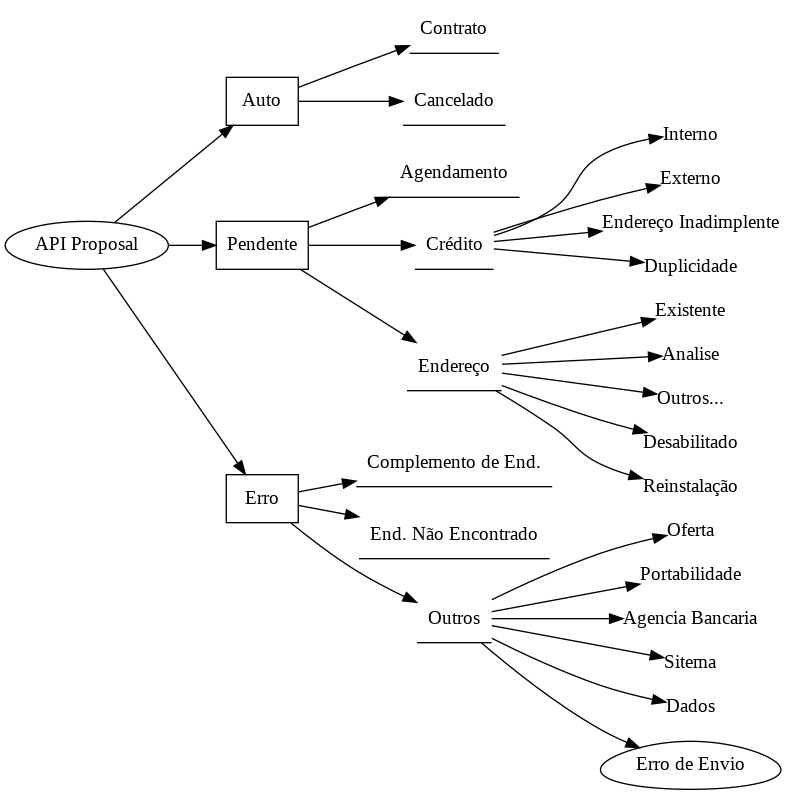

In [108]:
from IPython.display import Image
Image('Source.gv.png')